In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import defaultdict

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [3]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    searched = []
    found = []
    time = 0
    rss = 0
    threads = 1
    ds_type = None
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "Bifrost":
                            data[f"{ds_type}-{threads}"].append((time, rss))
                        else:
                            data[ds_type].append((time, rss))
            elif line.startswith("Saw "):
                elems = int(line.split()[1])
                searched.append(elems)
            elif line.startswith("matched"):
                elems = int(line.split()[1])
                found.append(elems)
            elif "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif line.startswith("threads"):
                threads = 32
    return {
        "size": sizes, 
        "searched": searched,
        "found": found,
        "data": data
    }

In [20]:
def plot_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] * 1000**3 / s for vv, s in zip(v, res["searched"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time ns / k-mer")
    plt.legend()
    plt.title("query time")
    a, b = plt.ylim()
    plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS bits / k-mer")
    plt.legend()
    plt.title("memory efficiency")
    a, b = plt.ylim()
    plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name)
    plt.show()

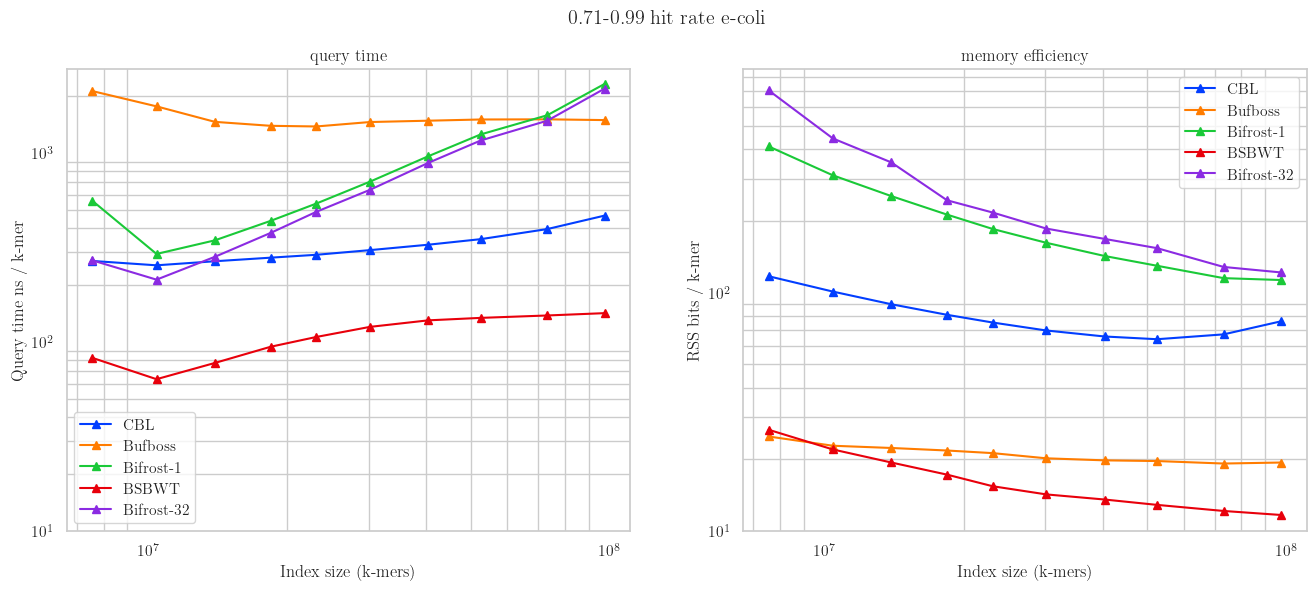

In [34]:
coli_res = read_res("../bbb_res/query_coli.txt")
h_r = [b / a for a, b in zip(coli_res["searched"], coli_res["found"])]
plot_time_and_space(coli_res, f"{h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli")

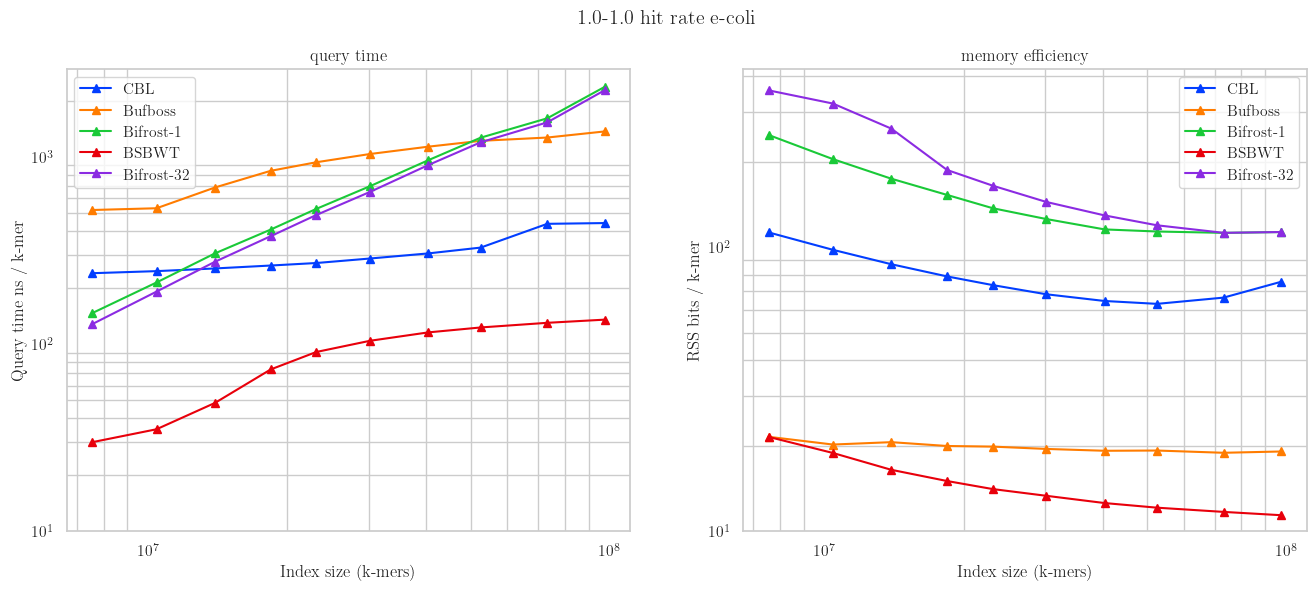

In [35]:
coli_res_pos = read_res("../bbb_res/query_coli_pos.txt")
h_r = [b / a for a, b in zip(coli_res_pos["searched"], coli_res_pos["found"])]
plot_time_and_space(coli_res_pos, f"{h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli")

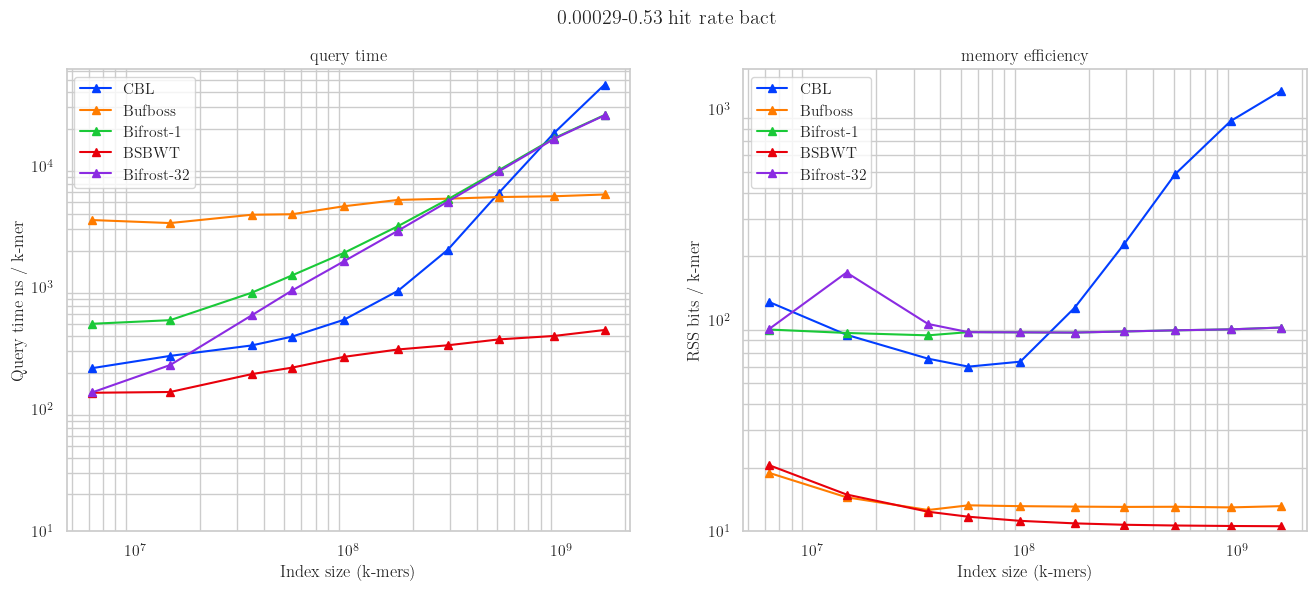

In [36]:
bact_res = read_res("../bbb_res/query_bact.txt")
h_r = [b / a for a, b in zip(bact_res["searched"], bact_res["found"])]
plot_time_and_space(bact_res, f"{h_r[0]:.2}-{h_r[-1]:.2} hit rate bact")

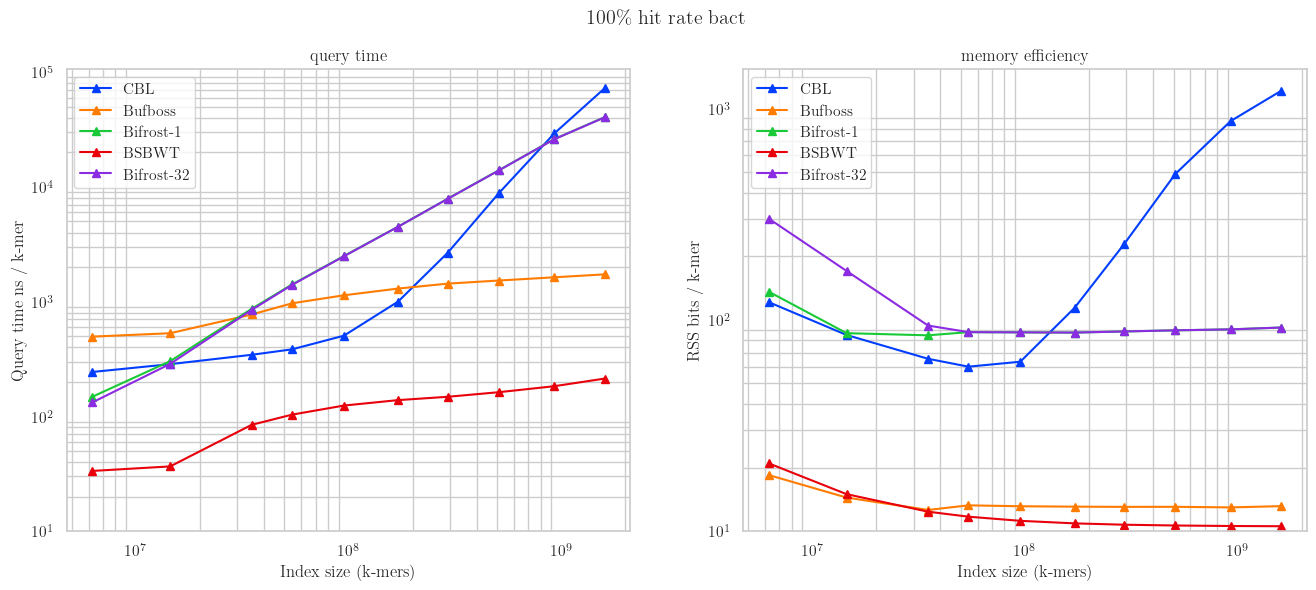

In [41]:
bact_res_pos = read_res("../bbb_res/query_bact_pos.txt")
h_r = [b / a for a, b in zip(bact_res_pos["searched"], bact_res_pos["found"])]
plot_time_and_space(bact_res_pos, "100\\% hit rate bact")